In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

In [2]:
from __future__ import print_function, division
from builtins import range, input

In [3]:
# re-size all the images to this
IMAGE_SIZE = [100, 100] # feel free to change depending on dataset

In [4]:
epochs = 3
batch_size = 32

In [5]:
train_path = 'C:/Users/eugur/Jupyter/Advanced_Deep_Learning/Blood_cells/Training'
valid_path = 'C:/Users/eugur/Jupyter/Advanced_Deep_Learning/Blood_cells/Validation'

In [6]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [7]:
# useful for getting number of classes
folders = glob(train_path + '/*')

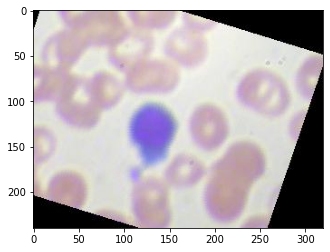

In [8]:
# look at an image for fun
plt.imshow(image.img_to_array(image.load_img(np.random.choice(image_files))).astype('uint8'))
plt.show()

In [9]:
# add preprocessing layer to the front of resnet
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [22]:
# # don't train existing weights
# for layer in inception.layers:
#   layer.trainable = False

In [11]:
# our layers - you can add more if you want
x = Flatten()(inception.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [12]:
# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [13]:
# view the structure of the model
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 49, 49, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 49, 49, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 49, 49, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [14]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

In [15]:
# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

In [16]:
# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 2487 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -1.0 max: 0.95826423


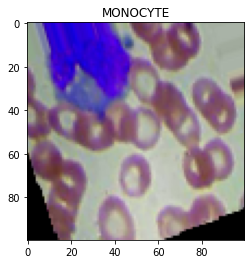

In [17]:
# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [18]:
# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [19]:
# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
311/311 [==============================] - 472s 2s/step - loss: 1.2936 - accuracy: 0.5259 - val_loss: 1231.7911 - val_accuracy: 0.2894
Epoch 2/3
311/311 [==============================] - 447s 1s/step - loss: 0.4637 - accuracy: 0.8438 - val_loss: 3.3531 - val_accuracy: 0.8145
Epoch 3/3
311/311 [==============================] - 427s 1s/step - loss: 0.3675 - accuracy: 0.8898 - val_loss: 2.3690 - val_accuracy: 0.6274


Generating confusion matrix 9957
Found 9957 images belonging to 4 classes.
50
100
150
[[2481    2    6    8]
 [  93 2350   10   30]
 [ 257  140 2069   12]
 [1795    5   10  689]]
Generating confusion matrix 2487
Found 2487 images belonging to 4 classes.
[[578   7  25  13]
 [ 29 586   4   1]
 [253  15 272  80]
 [506   0   6 112]]


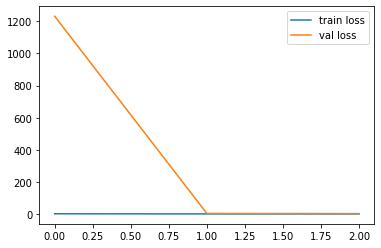

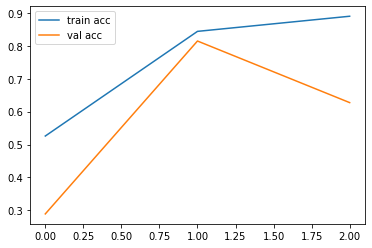

In [21]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm


cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)


# plot some data

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

